# Introduction

I'm diving into a project to create a model that can **translate from Singlish to English** because I think it’s important to preserve and understand local dialects.

Singlish has its own unique quirks and expressions, and I'm curious to see how well different models can tackle these challenges.

For this project, I’ll be training three Trasnformer models: **T5**, **BART**, and **mBART**, each chosen for their strengths in handling language tasks.

# Imports

In [2]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import torch
import evaluate
import string

from datasets import Dataset
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from transformers import Trainer, TrainingArguments, AutoTokenizer, MBart50Tokenizer, EarlyStoppingCallback, get_scheduler
from transformers import AutoModelForSeq2SeqLM, AutoModelForCausalLM

In [3]:
# Check if CUDA is available
is_cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {is_cuda_available}")

# Get the current device
current_device = torch.cuda.current_device() if is_cuda_available else "CPU"
print(f"Current Device: {current_device}")

# Get the name of the GPU (if available)
if is_cuda_available:
    gpu_name = torch.cuda.get_device_name(current_device)
    print(f"GPU Name: {gpu_name}")

CUDA Available: True
Current Device: 0
GPU Name: NVIDIA GeForce RTX 2080 SUPER


In [4]:
nltk.download('punkt_tab', quiet=True)

True

# Data Load

For this project, I unfortunately do not have ready access to a dedicated Singlish-English dataset.

To address this, I utilised a synthetic dataset generated by GPT-4, available on Hugging Face, which consists of 500 samples.

While this dataset may not be ideal, I believe it is sufficient to demonstrate the performance of the models in translating Singlish to English.

In [5]:
df = pd.read_csv("hf://datasets/gabrielchua/singlish-to-english-synthetic/singlish_to_english_v0.1.csv")

In [6]:
print("Dataset Shape:", df.shape)
print("Sample Data:")
print(df.sample(5))

Dataset Shape: (500, 3)
Sample Data:
     index                                           singlish  \
428    429  I watch the dance show on TV, then I also feel...   
101    102  Wah, the weather so hot, walk also can sweat b...   
191    192         Meditate ah, good for health one you know.   
145    146  I think the TV spoil already, cannot turn on leh.   
289    290  I go this shop before, their sewing materials ...   

                                               english  
428  After watching the dance show on TV, I also fe...  
101  Wow, the weather is so hot that you can sweat ...  
191           Meditating is good for health, you know.  
145        I think the TV is broken; it won't turn on.  
289  I've been to this shop before; their sewing ma...  


In [7]:
df["singlish"][0]

'Eh, you know how to chop the garlic not?'

In [8]:
len(df["singlish"][0])

40

In [9]:
nltk.sent_tokenize(df["singlish"][0].strip())

['Eh, you know how to chop the garlic not?']

In [10]:
df['singlish_length'] = df['singlish'].apply(len)
df['english_length'] = df['english'].apply(len)

In [11]:
print(df[['singlish_length', 'english_length']].describe())

       singlish_length  english_length
count       500.000000      500.000000
mean         53.872000       60.262000
std          12.553358       15.728322
min          22.000000       23.000000
25%          45.000000       49.000000
50%          54.000000       60.000000
75%          63.000000       70.000000
max          99.000000      113.000000


In [12]:
singlish_90th = np.percentile(df['singlish_length'], 90)
english_90th = np.percentile(df['english_length'], 90)

print(f"90th Percentile of Singlish Sentence Length: {singlish_90th}")
print(f"90th Percentile of English Sentence Length: {english_90th}")

90th Percentile of Singlish Sentence Length: 71.0
90th Percentile of English Sentence Length: 81.0


# Data Analysis

Before jumping into the translation task, I’ll take a quick look at the dataset to see how the sequences are structured. 

I plan to analyse the sequence lengths and use the 90th percentile (+ a buffer) to set a max length for tokenisation. This will help make sure I don’t cut off important info while training the models!

## Sequence Length Distribution

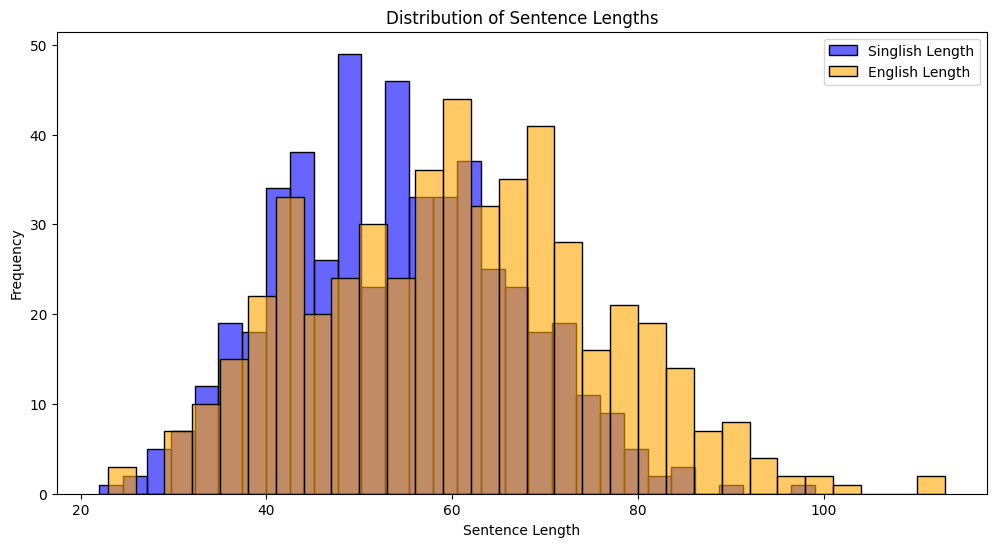

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(df['singlish_length'], bins=30, color='blue', alpha=0.6, label='Singlish Length')
sns.histplot(df['english_length'], bins=30, color='orange', alpha=0.6, label='English Length')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Word Frequency Distribution

In [14]:
singlish_words = [word for sentence in df['singlish'] for word in word_tokenize(sentence)]
singlish_word_freq = Counter(singlish_words)
print("Most Common Singlish Words:", singlish_word_freq.most_common(10))

Most Common Singlish Words: [(',', 498), ('.', 306), ('?', 229), ('I', 212), ('the', 187), ('you', 160), ('not', 128), ('to', 124), ('Eh', 99), ('can', 87)]


## Singlish Word Cloud

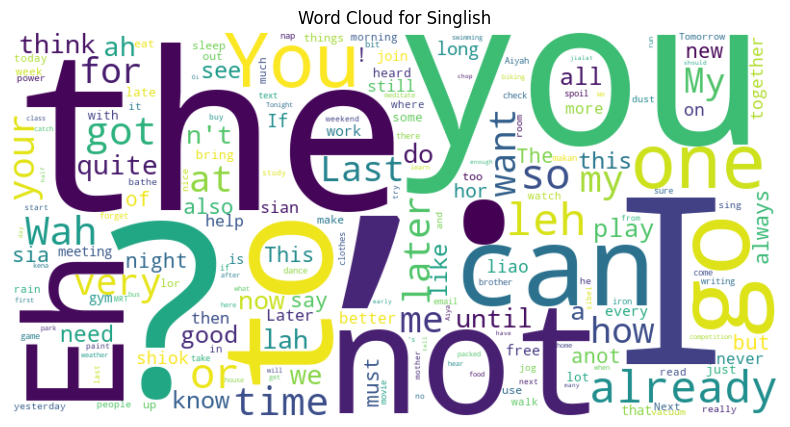

In [15]:
plt.figure(figsize=(10, 5))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(singlish_word_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Singlish')
plt.show()

## Vocabulary Size

In [16]:
singlish_vocab_size = len(set(singlish_words))
english_words = [word for sentence in df['english'] for word in nltk.word_tokenize(sentence)]
english_vocab_size = len(set(english_words))
print(f"Unique Words Count - Singlish: {singlish_vocab_size}, English: {english_vocab_size}")

Unique Words Count - Singlish: 1022, English: 1190


## N-gram Analysis

In [17]:
vectorizer = CountVectorizer(ngram_range=(2, 2), tokenizer=nltk.word_tokenize)
X = vectorizer.fit_transform(df['singlish'])
bigrams = X.toarray().sum(axis=0)
bigram_freq = dict(zip(vectorizer.get_feature_names_out(), bigrams))
sorted_bigrams = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)

print("Top 10 Bigrams in Singlish:")
print(sorted_bigrams[:10])

Top 10 Bigrams in Singlish:
[('eh ,', 99), ('not ?', 79), (', you', 77), ('or not', 51), ('leh .', 47), ('wah ,', 44), ('one .', 37), (', later', 35), (', the', 33), (', i', 31)]


C:\Users\yangy\Anaconda3\envs\rdai\lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [18]:
vectorizer = CountVectorizer(ngram_range=(3, 3), tokenizer=nltk.word_tokenize)
X = vectorizer.fit_transform(df['singlish'])
bigrams = X.toarray().sum(axis=0)
bigram_freq = dict(zip(vectorizer.get_feature_names_out(), bigrams))
sorted_bigrams = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)

print("Top 10 Trigrams in Singlish:")
print(sorted_bigrams[:10])

Top 10 Trigrams in Singlish:
[('eh , you', 50), ('or not ?', 46), ('eh , later', 23), ('wah , the', 20), ('last time i', 19), (", do n't", 17), ('i think i', 16), ('eh , do', 14), ('you want to', 13), (', you know', 12)]


In [19]:
vectorizer = CountVectorizer(ngram_range=(5, 5), tokenizer=nltk.word_tokenize)
X = vectorizer.fit_transform(df['singlish'])
bigrams = X.toarray().sum(axis=0)
bigram_freq = dict(zip(vectorizer.get_feature_names_out(), bigrams))
sorted_bigrams = sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)

print("Top 10 5-grams in Singlish:")
print(sorted_bigrams[:10])

Top 10 5-grams in Singlish:
[('i think i need to', 9), ('eh , later we go', 8), (', later you want to', 6), ('eh , later you want', 6), (", do n't disturb me", 4), (", do n't forget to", 4), (', you know how to', 4), ("do n't disturb me ,", 4), ("do n't like that lah", 4), ("eh , do n't disturb", 4)]


# Dataset Preparation

In [20]:
dataset = Dataset.from_pandas(df[['singlish', 'english']])
dataset

Dataset({
    features: ['singlish', 'english'],
    num_rows: 500
})

In [21]:
dataset = dataset.train_test_split(test_size=0.2)

In [22]:
dataset

DatasetDict({
    train: Dataset({
        features: ['singlish', 'english'],
        num_rows: 400
    })
    test: Dataset({
        features: ['singlish', 'english'],
        num_rows: 100
    })
})

In [23]:
prefix = "translate Singlish to English: "
max_input_length = int(max(singlish_90th, english_90th)) + 5  # Added some buffer
max_target_length = 64
batch_size = 8

In [24]:
def clean_text(text):
  sentences = nltk.sent_tokenize(text.strip())
  sentences_cleaned = [s for sent in sentences for s in sent.split("\n")]
  sentences_cleaned_no_titles = [sent for sent in sentences_cleaned
                                 if len(sent) > 0 and
                                 sent[-1] in string.punctuation]
  text_cleaned = "\n".join(sentences_cleaned_no_titles)
  return text_cleaned

In [25]:
clean_text(df["singlish"][0])

'Eh, you know how to chop the garlic not?'

# Model Training

For translating Singlish to English, I have chosen T5, BART, and mBART due to their unique strengths in handling this challenging task.

1. **T5 (Text-to-Text Transfer Transformer)**:  
   T5 treats all tasks as text-to-text problems, which is ideal for translation.

   Its extensive pre-training on diverse NLP tasks enhances its ability to generate accurate translations.

   The model's versatility allows it to effectively learn the relationships between Singlish and English, producing high-quality outputs.

3. **BART (Bidirectional and Auto-Regressive Transformers)**:  
   BART combines the benefits of both encoder and decoder architectures.

   As a denoising autoencoder, it is trained to reconstruct original text from corrupted versions, making it proficient at understanding context.

   This is essential for translating the informal and nuanced expressions characteristic of Singlish into grammatically correct English.

5. **mBART (Multilingual BART)**:  
   mBART is a multilingual variant of BART, pre-trained on diverse languages.

   Its ability to leverage multilingual knowledge is particularly useful for Singlish, which incorporates elements from various languages.

   mBART excels in scenarios with limited parallel data, making it a strong candidate for handling the complexities of Singlish.

## Tokenisation

In [26]:
t5_tokenizer = AutoTokenizer.from_pretrained("t5-small")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [27]:
def t5_tokenize_fn(examples):
    texts_cleaned = [clean_text(text) for text in examples['singlish']]
    inputs = ["translate Singlish to English: " + text for text in texts_cleaned]
    model_inputs = t5_tokenizer(inputs, max_length=max_input_length, truncation=True, padding="max_length")
    
    labels = t5_tokenizer(examples['english'], max_length=max_input_length, truncation=True, padding="max_length")
    model_inputs['labels'] = labels['input_ids']
    
    return model_inputs

In [28]:
tokenized_t5_dataset = dataset.map(t5_tokenize_fn, batched=True)
tokenized_t5_dataset

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['singlish', 'english', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 400
    })
    test: Dataset({
        features: ['singlish', 'english', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})

In [29]:
bart_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")
# bart_tokenizer.pad_token = bart_tokenizer.eos_token

C:\Users\yangy\Anaconda3\envs\rdai\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [30]:
def bart_tokenize_fn(examples):
    model_inputs = bart_tokenizer(examples['singlish'], max_length=max_input_length, truncation=True, padding="max_length")

    labels = bart_tokenizer(examples['english'], max_length=max_input_length, truncation=True, padding="max_length")
    model_inputs['labels'] = labels['input_ids']
        
    return model_inputs
    return model_inputs


In [31]:
tokenized_bart_dataset = dataset.map(bart_tokenize_fn, batched=True)
tokenized_bart_dataset

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['singlish', 'english', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 400
    })
    test: Dataset({
        features: ['singlish', 'english', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})

In [32]:
mbart_tokenizer = MBart50Tokenizer.from_pretrained("facebook/mbart-large-50", src_lang="en_XX", tgt_lang="en_XX")
mbart_tokenizer.pad_token = mbart_tokenizer.eos_token

In [33]:
def mbart_tokenize_fn(examples):
    model_inputs = mbart_tokenizer(examples['singlish'], max_length=max_input_length, truncation=True, padding="max_length")

    labels = mbart_tokenizer(examples['english'], max_length=max_input_length, truncation=True, padding="max_length")
    model_inputs['labels'] = labels['input_ids']
        
    return model_inputs

In [34]:
tokenized_mbart_dataset = dataset.map(mbart_tokenize_fn, batched=True)
tokenized_mbart_dataset

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['singlish', 'english', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 400
    })
    test: Dataset({
        features: ['singlish', 'english', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})

## Training

### T5 Model

In [35]:
t5_model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [36]:
t5_training_args = TrainingArguments(
    output_dir="./output/singlish-to-english-t5-finetuned",
    eval_strategy="epoch",
    eval_steps=50,
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="epoch",
    save_steps=100,
    warmup_steps=100,
    learning_rate=4e-5,
    lr_scheduler_type="linear",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=50,
    fp16=True,
    load_best_model_at_end=True,
)

In [37]:
t5_trainer = Trainer(
    model=t5_model,
    args=t5_training_args,
    train_dataset=tokenized_t5_dataset['train'],
    eval_dataset=tokenized_t5_dataset['test'],
    tokenizer=t5_tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

C:\Users\yangy\Anaconda3\envs\rdai\lib\site-packages\accelerate\accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [38]:
t5_trainer.train()

Epoch,Training Loss,Validation Loss
1,10.887600,7.959825
2,4.089600,0.522668
3,0.773800,0.424726
4,0.422900,0.283844
5,0.317300,0.238323
6,0.268700,0.220649
7,0.243300,0.208999
8,0.224500,0.201062
9,0.210300,0.195981
10,0.200400,0.193056


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=1550, training_loss=0.6664112912454913, metrics={'train_runtime': 324.5842, 'train_samples_per_second': 61.617, 'train_steps_per_second': 7.702, 'total_flos': 281891595878400.0, 'train_loss': 0.6664112912454913, 'epoch': 31.0})

In [39]:
t5_model.save_pretrained("./models/singlish-to-english-t5-finetuned")
t5_tokenizer.save_pretrained("./models/singlish-to-english-t5-finetuned")

('./singlish-to-english-t5-finetuned\\tokenizer_config.json',
 './singlish-to-english-t5-finetuned\\special_tokens_map.json',
 './singlish-to-english-t5-finetuned\\spiece.model',
 './singlish-to-english-t5-finetuned\\added_tokens.json',
 './singlish-to-english-t5-finetuned\\tokenizer.json')

### BART Model

In [40]:
bart_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-base")

In [41]:
bart_training_args = TrainingArguments(
    output_dir="./output/singlish-to-english-bart-finetuned",
    eval_strategy="epoch",
    eval_steps=50,
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="epoch",
    save_steps=100,
    warmup_steps=100,
    learning_rate=4e-5,
    lr_scheduler_type="linear",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=50,
    fp16=True,
    load_best_model_at_end=True,
)

In [42]:
bart_trainer = Trainer(
    model=bart_model,
    args=bart_training_args,
    train_dataset=tokenized_bart_dataset['train'],
    eval_dataset=tokenized_bart_dataset['test'],
    tokenizer=bart_tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

C:\Users\yangy\Anaconda3\envs\rdai\lib\site-packages\accelerate\accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [43]:
bart_trainer.train()

C:\Users\yangy\Anaconda3\envs\rdai\lib\site-packages\transformers\models\bart\modeling_bart.py:497: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss
1,11.457600,7.468865
2,4.116700,1.259421
3,0.638700,0.167248
4,0.161400,0.156602
5,0.091100,0.159045
6,0.058800,0.162071
7,0.041600,0.169880
8,0.027000,0.179348
9,0.024400,0.186804


C:\Users\yangy\Anaconda3\envs\rdai\lib\site-packages\transformers\modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=450, training_loss=1.8463607043690151, metrics={'train_runtime': 171.0569, 'train_samples_per_second': 116.92, 'train_steps_per_second': 14.615, 'total_flos': 184350007296000.0, 'train_loss': 1.8463607043690151, 'epoch': 9.0})

In [ ]:
bart_model.save_pretrained("./models/singlish-to-english-bart-finetuned")
bart_tokenizer.save_pretrained("./models/singlish-to-english-bart-finetuned")

### mBART Model

In [44]:
mbart_model = AutoModelForSeq2SeqLM.from_pretrained("facebook/mbart-large-50")

In [45]:
mbart_training_args = TrainingArguments(
    output_dir="./output/singlish-to-english-mbart-finetuned",
    eval_strategy="epoch",
    eval_steps=50,
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="epoch",
    save_steps=100,
    warmup_steps=100,
    learning_rate=4e-5,
    lr_scheduler_type="linear",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=50,
    fp16=True,
    load_best_model_at_end=True,
)

In [46]:
mbart_trainer = Trainer(
    model=mbart_model,
    args=mbart_training_args,
    train_dataset=tokenized_mbart_dataset['train'],
    eval_dataset=tokenized_mbart_dataset['test'],
    tokenizer=mbart_tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

C:\Users\yangy\Anaconda3\envs\rdai\lib\site-packages\accelerate\accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [47]:
mbart_trainer.train()

Epoch,Training Loss,Validation Loss
1,8.408200,0.866042
2,0.711400,0.415363
3,0.255100,0.200182
4,0.079700,0.208818
5,0.046900,0.203484
6,0.045600,0.223409
7,0.026800,0.214957
8,0.023900,0.211832


C:\Users\yangy\Anaconda3\envs\rdai\lib\site-packages\transformers\modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200, 'early_stopping': True, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=400, training_loss=1.1996992263197899, metrics={'train_runtime': 3714.1305, 'train_samples_per_second': 5.385, 'train_steps_per_second': 0.673, 'total_flos': 582416125132800.0, 'train_loss': 1.1996992263197899, 'epoch': 8.0})

In [48]:
mbart_model.save_pretrained("./models/singlish-to-english-mbart-finetuned")
mbart_tokenizer.save_pretrained("./models/singlish-to-english-mbart-finetuned")

('./models/singlish-to-english-mbart-finetuned\\tokenizer_config.json',
 './models/singlish-to-english-mbart-finetuned\\special_tokens_map.json',
 './models/singlish-to-english-mbart-finetuned\\sentencepiece.bpe.model',
 './models/singlish-to-english-mbart-finetuned\\added_tokens.json')

# Models Evaluation

For evaluating Singlish-to-English translation, BLEU, ROUGE, and average sentence length were used:

- **BLEU** measures the overlap of n-grams between the predicted and reference translations. It provides a sense of fluency and accuracy in capturing exact words or phrases.

- **ROUGE** focuses more on recall, especially useful for tasks with varied phrasing, assessing how much relevant content is captured by the model.

- **Average Sentence Length** checks how closely the generated sentences match the reference length, important in translation tasks where brevity or verbosity may affect meaning.

These metrics together offer a balanced evaluation of precision, recall, and sentence structure in translation.

In [49]:
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

In [50]:
def t5_inference(text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = t5_tokenizer("translate Singlish to English: " + text, return_tensors="pt", truncation=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    outputs = t5_model.generate(**inputs, num_beams=8, do_sample=True , max_length=max_input_length)

    return t5_tokenizer.decode(outputs[0], skip_special_tokens=True)

In [51]:
def bart_inference(text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = bart_tokenizer(text, return_tensors="pt", max_length=max_input_length, truncation=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    outputs = bart_model.generate(**inputs, max_length=max_input_length)
    return bart_tokenizer.decode(outputs[0], skip_special_tokens=True)

In [52]:
def mbart_inference(text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = mbart_tokenizer(text, return_tensors="pt", max_length=max_input_length, truncation=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    outputs = mbart_model.generate(**inputs, max_length=max_input_length)
    return mbart_tokenizer.decode(outputs[0], skip_special_tokens=True)

In [80]:
def evaluate_model(model_fn, dataset, num_samples=100):
    predictions = []
    references = []
    sentence_lengths = []
    
    for i in range(num_samples):
        singlish_sentence = dataset['test'][i]['singlish']
        english_sentence = dataset['test'][i]['english']
        
        predicted_sentence = model_fn(singlish_sentence)
        predictions.append(predicted_sentence)
        references.append([english_sentence])
        sentence_lengths.append(len(predicted_sentence.split()))
        
    bleu_score = bleu.compute(predictions=predictions, references=references)
    rouge_score = rouge.compute(predictions=predictions, references=references)
    avg_sentence_length = np.mean(sentence_lengths)
    
    return bleu_score, rouge_score, avg_sentence_length

In [81]:
t5_bleu, t5_rouge, t5_avg_len = evaluate_model(t5_inference, dataset)

In [82]:
bart_bleu, bart_rouge, bart_avg_len = evaluate_model(bart_inference, dataset)

In [83]:
mbart_bleu, mbart_rouge, mbart_avg_len = evaluate_model(mbart_inference, dataset)

In [104]:
english_sentence_lengths = []

for split in ['train', 'test']:
    for sample in dataset[split]:
        english_sentence = sample['english']
        english_sentence_lengths.append(len(english_sentence.split()))

avg_english_sentence_length = np.mean(english_sentence_lengths)

In [88]:
models = ['T5', 'BART', 'mBART']

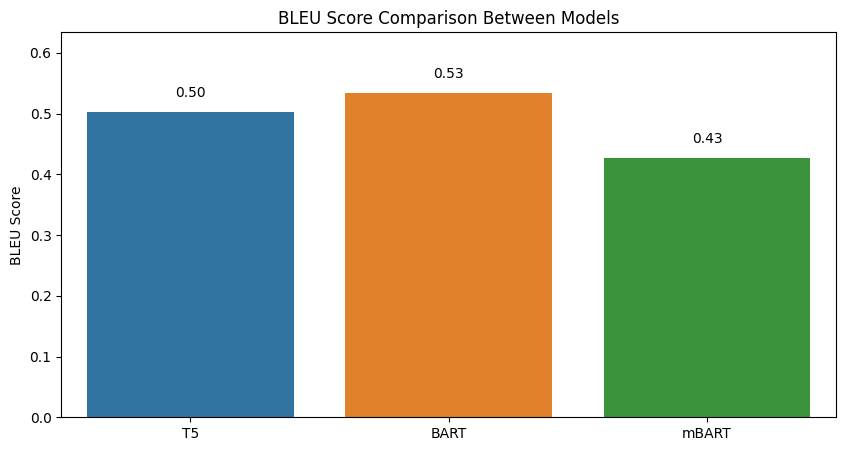

In [94]:
bleu_scores = [t5_bleu['bleu'], bart_bleu['bleu'], mbart_bleu['bleu']]

plt.figure(figsize=(10,5))
sns.barplot(x=models, y=bleu_scores, hue=models)
plt.title('BLEU Score Comparison Between Models')
plt.ylabel('BLEU Score')

plt.ylim(0, max(bleu_scores) + 0.1)

for i, score in enumerate(bleu_scores):
    plt.text(i, score + 0.02, f'{score:.2f}', ha='center', va='bottom')

plt.show()

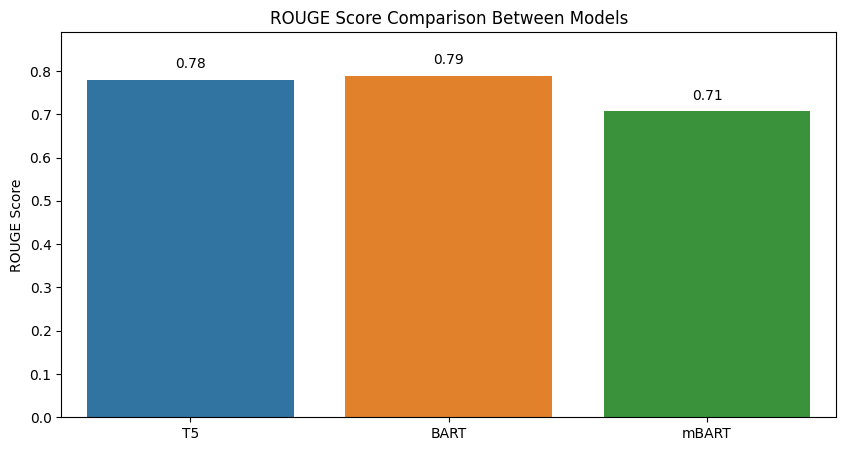

In [95]:
rouge_scores = [t5_rouge['rouge1'], bart_rouge['rouge1'], mbart_rouge['rouge1']]

plt.figure(figsize=(10,5))
sns.barplot(x=models, y=rouge_scores, hue=models)
plt.title('ROUGE Score Comparison Between Models')
plt.ylabel('ROUGE Score')

plt.ylim(0, max(rouge_scores) + 0.1)

for i, score in enumerate(rouge_scores):
    plt.text(i, score + 0.02, f'{score:.2f}', ha='center', va='bottom')

plt.show()

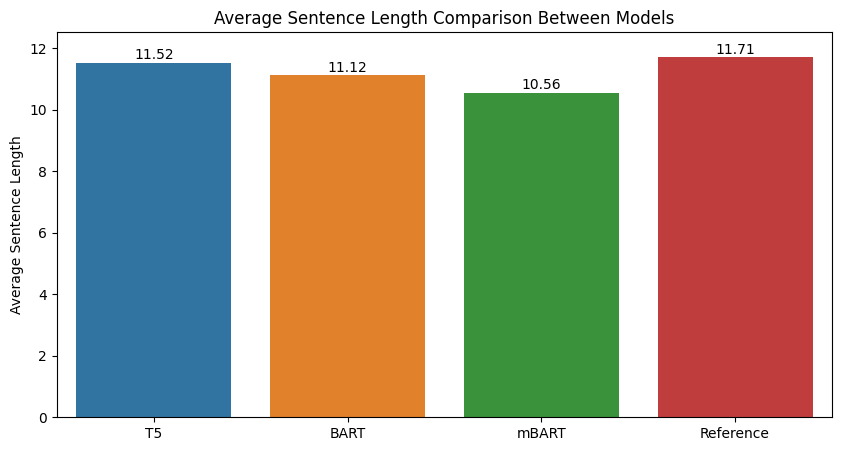

In [107]:
avg_sen_lens = [t5_avg_len, bart_avg_len, mbart_avg_len]

plt.figure(figsize=(10,5))
sns.barplot(x=models+["Reference"], y=avg_sen_lens+[avg_english_sentence_length], hue=models+["Reference"])
plt.title('Average Sentence Length Comparison Between Models')
plt.ylabel('Average Sentence Length')

plt.ylim(0, max(avg_sen_lens) + 1)

for i, score in enumerate(avg_sen_lens+[avg_english_sentence_length]):
    plt.text(i, score + 0.02, f'{score:.2f}', ha='center', va='bottom')

plt.show()

Based on the evaluation results using a small training dataset of 500 samples:
- **BART**:
    - BART slightly outperforms T5 and mBART, achieving the highest BLEU (0.53) and ROUGE (0.79) scores
    - BART also produced an average sentence length of 11.12, which is closest to the dataset's average reference sentence length of 11.71
    - This suggests BART's strong contextual understanding for handling Singlish-to-English translation
- **T5**:
    - T5 follows closely, with a BLEU score of 0.5, ROUGE of 0.78,  
    - T5 also produced an average sentence length of 11.52, which is closest to the dataset's average reference sentence length of 11.71
    - This indicates T5's strong alignment with typical sentence structures in the dataset 
- **mBART**:
    - With a BLEU of 0.43, ROUGE of 0.71, and shorter average sentence length of 10.56, mBART appears less effective in capturing the nuances of Singlish, possibly due to its multilingual focus

Given the small training dataset of only 500 samples, performance differences may shift with more data. BART’s ability to align with the average sentence length suggests it could maintain its strong performance, while T5’s versatile pretraining may lead to improvements as the dataset size increases.

# Inference

In the set of sample Singlish sentences, I intentionally included two distinct examples that appear similar in English but carry fundamentally different meanings in Singlish:

- *"Wah do like this can ah?"*: Can this be done this way?
- *"Wah do like this can meh?"*: Is doing this like that appropriate?

Although I don’t expect any of the three models to accurately capture these nuances — primarily because the training dataset lacks such specific examples — I found it interesting to observe how they handle these subtle distinctions.

In [97]:
sample_singlish_sentences = [
    "I going to the kopitiam later, you want to come?",
    "Later you going for class or not?",
    "This class like good sia",
    "Wah do like this can ah?",
    "Wah do like this can meh?"]

In [98]:
t5_outputs = []
for sample in sample_singlish_sentences:
    t5_output = t5_inference(sample)
    t5_outputs.append(t5_output)

In [99]:
for index, (sample, output) in enumerate(zip(sample_singlish_sentences, t5_outputs), start=1):
    print(f"Sample {index}: {sample}")
    print(f"T5 Output: {output}\n")

Sample 1: I going to the kopitiam later, you want to come?
T5 Output: I'm going to the kopitiam later, do you want to come?

Sample 2: Later you going for class or not?
T5 Output: Are you going for class later?

Sample 3: This class like good sia
T5 Output: This class is like a good one

Sample 4: Wah do like this can ah?
T5 Output: Wow, do you like this?

Sample 5: Wah do like this can meh?
T5 Output: Wow, can you do this?



In [100]:
bart_outputs = []
for sample in sample_singlish_sentences:
    bart_output = bart_inference(sample)
    bart_outputs.append(bart_output)

In [101]:
for index, (sample, output) in enumerate(zip(sample_singlish_sentences, bart_outputs), start=1):
    print(f"Sample {index}: {sample}")
    print(f"BART Output: {output}\n")

Sample 1: I going to the kopitiam later, you want to come?
BART Output: I'm going to the kopitiam later, do you want to come?

Sample 2: Later you going for class or not?
BART Output: Are you going for class later?

Sample 3: This class like good sia
BART Output: This class is like good sia.

Sample 4: Wah do like this can ah?
BART Output: Wow, can you do something like this?

Sample 5: Wah do like this can meh?
BART Output: Wow, can you do something like this?



In [102]:
mbart_outputs = []
for sample in sample_singlish_sentences:
    mbart_output = mbart_inference(sample)
    mbart_outputs.append(mbart_output)

In [103]:
for index, (sample, output) in enumerate(zip(sample_singlish_sentences, mbart_outputs), start=1):
    print(f"Sample {index}: {sample}")
    print(f"mBART Output: {output}\n")

Sample 1: I going to the kopitiam later, you want to come?
mBART Output: I'm going to the coffee shop later, do you want to come over?

Sample 2: Later you going for class or not?
mBART Output: Hey, are you going for class later?

Sample 3: This class like good sia
mBART Output: Hey, this class was really good!

Sample 4: Wah do like this can ah?
mBART Output: Hey, can you do this like this?

Sample 5: Wah do like this can meh?
mBART Output: Hey, can you do this like this?



The first three samples were effectively translated by all three models. 

However, as anticipated, the last two samples posed challenges, resulting in poorer performance across the board. To improve future translations, the training dataset can be enriched with similar examples to enhance the models' ability to learn and adapt.